In [44]:
#import required Libraries 
import cv2
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np
import math
from numpy import linalg as LA
from skimage import segmentation
from skimage.filters import gaussian
from skimage.feature import canny


In [45]:
# Take the input of content and style image and resize them to 400x400

imsize = 400

content = cv2.imread("./images/house 2-small.jpg")
content = cv2.cvtColor(content, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0

content = content[0:imsize, 0:imsize]

style = cv2.imread("./images/starry-night - small.jpg")
style = cv2.cvtColor(style, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
style = style[0:imsize, 0:imsize]

(-0.5, 399.5, 399.5, -0.5)

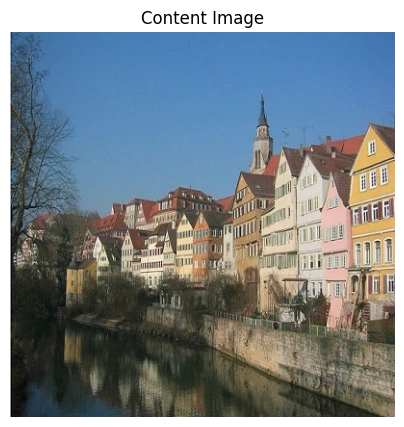

In [46]:
plt.figure(figsize=(5,5))
plt.imshow(content)
plt.title("Content Image")
plt.axis("off")

(-0.5, 399.5, 399.5, -0.5)

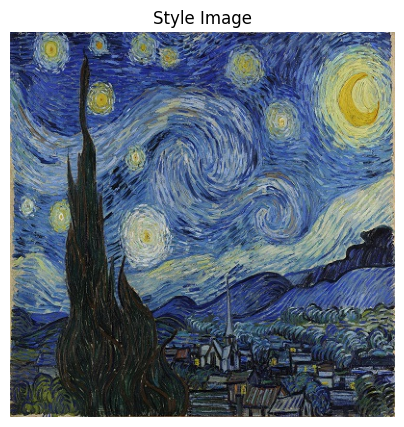

In [47]:
plt.figure(figsize=(5,5))
plt.imshow(style)
plt.title("Style Image")
plt.axis("off")

In [48]:
def nearest_n(R, X, Q_size, S, h, w, c, Pp, Vp, Pstride, mp, L, gap):
  
    S = S.reshape((h, w, c))
    RX = X[R==1]
    RXp = np.dot(Vp.T, (RX - mp))
    dif = np.tile(RXp[:, np.newaxis], (1, Pp.shape[1])) - Pp
    sqr = np.sum(dif**2, axis=0)
    sqr = sqr + 0.1 * np.min(sqr) * np.random.randn(sqr.size)
    idx = np.argmin(sqr)
    ks, ls = np.unravel_index(idx//4, ((w-Q_size+1-1)//Pstride+1, (h-Q_size+1-1)//Pstride+1))
    ks = (ks)*Pstride
    ls = (ls)*Pstride

    ks_start, ks_end = max(ks, 0), min(ks+Q_size, h)
    ls_start, ls_end = max(ls, 0), min(ls+Q_size, w)
  
    ang = (idx+3)%4 
    z = S[ks_start:ks_end, ls_start:ls_end, :]
    z = z.reshape(-1)
    return ks, ls, z, ang


In [49]:
def irls(R, X, z):
    tNc, Nij = R.shape
    Xk = X 

    r = 0.8
    value = np.sum(R, axis=1)
    logical_array = value > 0
   
    
    unsampled_pixs = np.double(~logical_array)

    A = unsampled_pixs 
    B = Xk * unsampled_pixs

    for i in range(Nij):
        tm = Xk[R[:,i] == 1]
        diff = tm - z[:,i]
        new_diff = diff**2
        c = 1e-10
        new_diff = np.add(new_diff,c)
        w = np.sum(new_diff)
        w=w**((r-2)/2)

        A = A + w * R[:, i]
        temp = R[:,i]
        temp[temp==1] = z[:,i]
        B = B + w * temp

    A = np.add(A, 1e-10)
    Xk = (1 / (A)) * B
    
    return Xk

In [50]:
# function for color transfer
def color_transfer(C0, S0):
    c=3
    for channel in range(c):
        C0[:, :, channel] = exposure.match_histograms(C0[:, :, channel], S0[:, :, channel])
    C0 = C0.reshape(-1)
    return C0

In [51]:

def style_transfer(content, style, hall, mask0, hallcoeff, Wcoeff, patch_sizes, scales, imsize):
    
    gap_sizes=[28 ,18, 9, 6]
    
    C0 = content
    C0 = C0.reshape(-1)
    S0 = style.reshape(-1)

    h0 = imsize
    w0 = imsize
    c = 3
    
    C0 = C0.reshape(h0, w0, c)
    S0 = S0.reshape(h0, w0, c)

    X = color_transfer(C0, S0)
    
  

    # Adding noise to prevent repetitive patches
    X = X + np.max(X) * np.random.randn(X.size)
    
    for L in scales:
        
        # scaling the images and mask by factor of L
        C_scaled = cv2.resize(C0.reshape((h0, w0, c)), (0,0), fx=1/L, fy=1/L)
        S_scaled = cv2.resize(S0.reshape((h0, w0, c)), (0,0), fx=1/L, fy=1/L)
        X = cv2.resize(X.reshape((h0, w0, c)), (0,0), fx=1/L, fy=1/L)
        mask = cv2.resize(mask0, (0,0), fx=1/L, fy=1/L)
        halls = cv2.resize(hall, (0,0), fx=1/L, fy=1/L)

        h = np.ceil(h0/L).astype(int)
        w = np.ceil(w0/L).astype(int)


        C = C_scaled.reshape(-1)
        S = S_scaled.reshape(-1)
        X = X.reshape(-1)

        # for each scale loop over patch size
        for n in patch_sizes:

            Q_size = n
            Pstride = 4
            S = S.reshape((h, w, c))

            numpatches =(int(((h - Q_size + 1) - 1) / Pstride) + 1) * (int(((w - Q_size + 1) - 1) / Pstride) + 1) 
            numpatches = numpatches * 4  
            P = np.zeros((c * Q_size * Q_size, numpatches))
 
            # making the array that stores patch information
            for k in range(0, h - Q_size + 1, Pstride):
                for j in range(0, w - Q_size + 1, Pstride):
                    patch = S[k:k+Q_size, j:j+Q_size, :]
                    for l in range(4):
                        temp = np.rot90(patch,l)
                        P[:, (int(k / Pstride)) * (int((w - Q_size + 1 - 1) / Pstride) + 1) * 4 + (int(j / Pstride)) * 4 + l] = temp.flatten()
           
            
            # Computing covariance matrix for PCA
            S = S.reshape(-1)
            mp = np.mean(P, axis=1)
            result_matrix = mp.reshape(-1, 1)
            num_cols = P.shape[1]
            expanded_means = np.repeat(result_matrix, num_cols, axis=1)
            P = P - expanded_means
            CoP = np.dot(P, P.T)
        

            D, V = np.linalg.eigh(CoP)
            sorted_indices = np.argsort(D)[::-1]
            
            D_sorted = D[sorted_indices]
            V_sorted = V[:, sorted_indices]
         
            eig_idx = 0
            energy = 0
            total_energy = sum(D_sorted)

            for i in range(len(D_sorted)):
                energy += D_sorted[i]
                if energy >= 0.95 * total_energy:
                    eig_idx = i
                    break
            
            Vp = V_sorted[:, :eig_idx+1]
            Pp = np.dot(Vp.T, P) 

            # This stores the top vectors that contribute to 95% of the energy
        
            for k in range(3):
                
                # STEP 1 : STYLE FUSION

                X = hallcoeff * halls.reshape(-1) + (1 - hallcoeff) * X.reshape(-1) 

                

                # STEP 2 : PATCH MATCHING   
                # we report the original patch in the style image that corresponds to the chosen projected patch as most similar to the given content patch (i,j)                 
                gap = next(gap for gap, size in zip(gap_sizes, patch_sizes) if size == n)
                num_patch = (math.floor(((h - Q_size + 1) - 1) / gap) + 1) * (math.floor(((w - Q_size + 1) - 1) / gap) + 1)
                Rall = np.zeros((h * w * c, num_patch))
                z = np.zeros((c * n**2, num_patch))
                
                for i in range(0, h-Q_size+1, gap):
                    for j in range(0, w-Q_size+1, gap):
                        R = np.zeros((h, w, c))
                        R[i:i+Q_size, j:j+Q_size, :] = 1
                        R = R.reshape(-1)

                        Rall[:, (math.ceil(i / gap) ) * (math.floor(((w - Q_size + 1) - 1) / gap) + 1) + math.ceil(j / gap)] = R

                        ks, ls, zij, ang = nearest_n(R, X, Q_size, S, h, w, c, Pp, Vp, Pstride, mp, L, gap)
                        temp = np.rot90(zij.reshape((n, n, c)), int(ang), axes=(0, 1))
                        z[:, (math.ceil(i / gap) ) * (math.floor(((w - Q_size + 1) - 1) / gap) + 1) + math.ceil(j / gap)]=temp.reshape(-1)


                

                # STEP 3 : STYLE SYNTHESIS
                # each i, j patch in the output image should roughly match the corresponding NN style patch, zij . 
                
                Xtilde = irls(Rall, X, z)
              
                # 4. CONTENT FUSION  

                # To ensure that the original content is preserved, we use a pixel-by-pixel weighted average of the content image and the estimated style image              
              
                num_cols = c
                flat_mask = mask.flatten()
                flat_mask = flat_mask / np.max(flat_mask)
                replicated_matrix = Wcoeff * flat_mask
                W = np.repeat(replicated_matrix, num_cols, axis=0)
                
                new_one = np.ones(W.shape)
                new_one = new_one + W
                new_one = 1/new_one
                second_mat = Xtilde + W*C
                Xhat = new_one * second_mat

                # 5. COLOR TRANSFER
                # Initialize C to color palette of S using histogram matching since S more diversity
                Xhat = Xhat.reshape(h, w, c)
                S = S.reshape(h, w, c)
                X = X.reshape(h,w,c)

                for channel in range(c):
                    X[:, :, channel] = exposure.match_histograms(Xhat[:, :, channel], S[:, :, channel])

                
                
        # rescaling the image
        if L > 1:
            X = np.reshape(X, (h, w, c))
            X = cv2.resize(X, None, fx=L, fy=L, interpolation=cv2.INTER_LINEAR)
            X = X.flatten()

        X = X.reshape((imsize, imsize, 3))

    return X  

In [52]:
# Lastly, to make transitions between high content areas and high-style areas smoother, we apply a Gaussian smoothing to the mask

def segment(C, scale):
    sigma_edge = scale * 1
    sigma_blur = scale * 7
    gray_C = cv2.cvtColor(C, cv2.COLOR_RGB2GRAY)
    E = canny(gray_C, sigma=sigma_edge)
    B = gaussian(0.5 * E, sigma=sigma_blur)
    mask = B > np.mean(B)
    BW = segmentation.active_contour(B, mask)
    BW = BW[:, 0].astype(float)  
    BW = np.resize(BW, E.shape)
    W = gaussian((BW + 10 * E).astype(float), sigma=sigma_blur)
    return W

In [53]:
imsize = 400 
blurred_content = cv2.GaussianBlur(content, ksize=(0, 0), sigmaX=100, borderType=cv2.BORDER_REPLICATE)

hall = style_transfer(
    blurred_content,        # content with noise
    style,                  # style
    np.ones((400, 400, 3)), # hall 
    np.ones((400, 400)),    # mask
    0,                      # hall coefficient
    0,                      # content weight
    [36,22],                # patch sizes
    [4,1],                  # scales
    imsize                  # image size
)

(-0.5, 399.5, 399.5, -0.5)

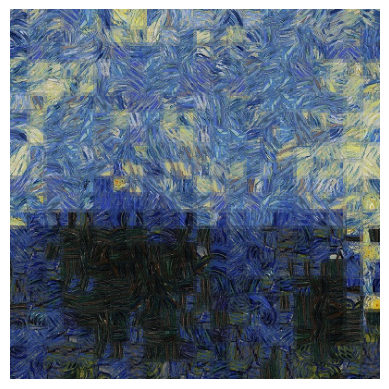

In [54]:
plt.imshow(hall)
plt.axis("off")

(-0.5, 399.5, 399.5, -0.5)

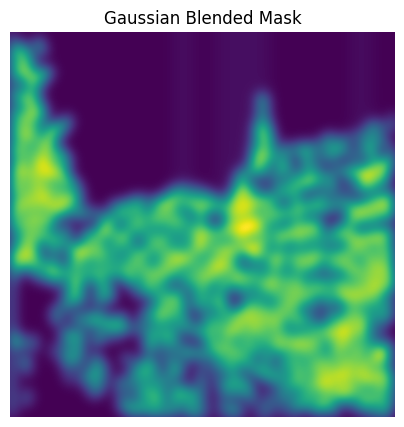

In [55]:
content3 = cv2.imread("./images/house 2-small copy.jpg")
content3 = cv2.cvtColor(content3, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
content3 = content3[0:imsize, 0:imsize]

stylee = cv2.imread("./images/starry-night - small.jpg")
stylee = cv2.cvtColor(stylee, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
stylee = stylee[0:imsize, 0:imsize]

segmented =  segment((content3), 1)

# show the gaussian blended image as well
plt.figure(figsize=(5,5))
plt.imshow(segmented)
plt.title("Gaussian Blended Mask")
plt.axis("off")



In [57]:
est_img=style_transfer(
    content3,
    style,
    hall,
    segmented,
    0.25,
    1.5,
    [36,22],
    [4,1],
    imsize
)

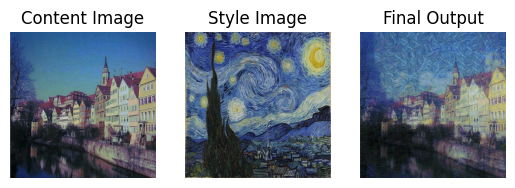

In [58]:
# Create a subplot with 1 row and 3 columns
plt.subplot(1, 3, 1)
plt.imshow(content3)
plt.title('Content Image')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(stylee)
plt.title('Style Image')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(est_img)
plt.title('Final Output')
plt.axis("off")

# Display the plot
plt.show()


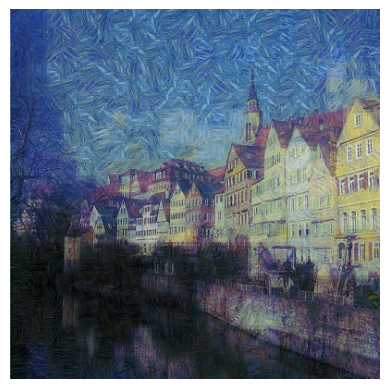

In [59]:
plt.imshow(est_img)
plt.axis("off")
plt.savefig('output_image.png')
plt.show()


In [60]:
# DONE THANKS